In [2]:
:dep rand = "*"

/*
------------------------------------------------------------------------------------------------
Will be replaced with an import command once the project reachesd 1.0
------------------------------------------------------------------------------------------------
*/
use rand::Rng;

pub struct Neuron {
    w: Vec<Value>,
    b: Value,
    nonlin: bool,
}

impl Neuron {
    pub fn new(nin: usize, nonlin: bool) -> Neuron {
        Neuron {
            w: (0..nin).map(|_| Value::from(rand::thread_rng().gen_range(-1.0..=1.0))).collect(),
            b: Value::from(rand::thread_rng().gen_range(-1.0..=1.0)),
            nonlin,
        }
    }

    pub fn forward(&self, x: &Vec<Value>) -> Value {
        let out = (std::iter::zip(&self.w, x)
            .map(|(wi, xi)| wi * xi)
            .collect::<Vec<_>>()
            .into_iter()
            .reduce(|a, b| a + b)
            .unwrap())
            + self.b.clone();
        if self.nonlin {
            out.relu()
        } else {
            out
        }
    }

    pub fn parameters(&self) -> Vec<Value> {
        [self.w.clone(), vec![self.b.clone()]].concat()
    }
}

impl std::fmt::Debug for Neuron {
    fn fmt(&self, f: &mut std::fmt::Formatter<'_>) -> std::fmt::Result {
        write!(f, "{}Neuron({})", if self.nonlin { "ReLU" } else { "Linear" }, self.w.len())
    }
}

pub struct Layer {
    neurons: Vec<Neuron>,
}

impl Layer {
    pub fn new(nin: usize, nout: usize, nonlin: bool) -> Layer {
        Layer {
            neurons: (0..nout).map(|_| Neuron::new(nin, nonlin)).collect(),
        }
    }

    pub fn forward(&self, x: &Vec<Value>) -> Vec<Value> {
        self.neurons.iter().map(|i| i.forward(x)).collect::<Vec<_>>()
    }

    pub fn parameters(&self) -> Vec<Value> {
        self.neurons.iter().flat_map(|neuron| neuron.parameters()).collect()
    }
}

impl std::fmt::Debug for Layer {
    fn fmt(&self, f: &mut std::fmt::Formatter<'_>) -> std::fmt::Result {
        write!(
            f,
            "Layer of [{:?}]",
            self.neurons.iter().map(|n| format!("{:?}", n)).collect::<Vec<_>>().join(", ")
        )
    }
}

pub struct MLP {
    layers: Vec<Layer>,
}

impl MLP {
    pub fn new(nin: usize, nouts: Vec<usize>, nonlin: bool) -> MLP {
        MLP {
            layers: (0..nouts.len())
                .map(|i| {
                    Layer::new(
                        vec![nin].into_iter().chain(nouts.clone().into_iter()).collect::<Vec<_>>()[i],
                        nouts[i],
                        nonlin,
                    )
                })
                .collect(),
        }
    }

    pub fn forward(&self, x: Vec<Value>) -> Vec<Value> {
        self.layers.iter().fold(x, |x, layer| layer.forward(&x))
    }

    pub fn parameters(&self) -> Vec<Value> {
        self.layers.iter().flat_map(|layer| layer.parameters()).collect()
    }
}

impl std::fmt::Debug for MLP {
    fn fmt(&self, f: &mut std::fmt::Formatter<'_>) -> std::fmt::Result {
        write!(
            f,
            "MLP of [{}]",
            self.layers.iter().map(|l| format!("{:?}", l)).collect::<Vec<_>>().join(", ")
        )
    }
}
use std::cell::{Ref, RefCell};
use std::collections::HashSet;
use std::rc::Rc;

#[derive(Clone, Eq, PartialEq, Debug)]
pub struct Value(Rc<RefCell<Values>>);

pub struct Values {
    data: f64,
    grad: f64,
    op: Option<String>,
    prev: Vec<Value>,
    _backward: Option<fn(value: &Ref<Values>)>,
}

impl Values {
    fn new(data: f64, op: Option<String>, prev: Vec<Value>, _backward: Option<fn(value: &Ref<Values>)>) -> Values {
        Values {
            data,
            grad: 0.0,
            op,
            prev,
            _backward,
        }
    }
}

impl Value {
    pub fn from<T: Into<Value>>(t: T) -> Value {
        t.into()
    }

    fn new(value: Values) -> Value {
        Value(Rc::new(RefCell::new(value)))
    }

    pub fn data(&self) -> f64 {
        self.borrow().data
    }

    pub fn grad(&self) -> f64 {
        self.borrow().grad
    }

    pub fn zero_grad(&self) {
        self.borrow_mut().grad = 0.0;
    }

    pub fn adjust(&self, val: f64) {
        let mut value = self.borrow_mut();
        value.data += val * value.grad;
    }

    pub fn add(a: &Value, b: &Value) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            out.prev[0].borrow_mut().grad += out.grad;
            out.prev[1].borrow_mut().grad += out.grad;
        };

        Value::new(Values::new(
            a.borrow().data + b.borrow().data,
            Some("+".to_string()),
            vec![a.clone(), b.clone()],
            Some(_backward),
        ))
    }

    pub fn mul(a: &Value, b: &Value) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            let a_data = out.prev[0].borrow().data;
            let b_data = out.prev[1].borrow().data;
            out.prev[0].borrow_mut().grad += b_data * out.grad;
            out.prev[1].borrow_mut().grad += a_data * out.grad;

        };

        Value::new(Values::new(
            a.borrow().data * b.borrow().data,
            Some("*".to_string()),
            vec![a.clone(), b.clone()],
            Some(_backward),
        ))
    }

    pub fn pow(&self, other: &Value) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            let mut base = out.prev[0].borrow_mut(); // I want to remove this
            base.grad += out.prev[1].borrow().data * (base.data.powf(out.prev[1].borrow().data - 1.0)) * out.grad;
        };

        Value::new(Values::new(
            self.borrow().data.powf(other.borrow().data),
            Some("^".to_string()),
            vec![self.clone(), other.clone()],
            Some(_backward),
        ))
    }

    // Negative power ie x^-1, this will allow us to divide
    pub fn powneg(&self) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            let mut base = out.prev[0].borrow_mut(); // and remove this
            base.grad += -(1.0 / base.data.powf(2.0)) * out.grad;
        };

        Value::new(Values::new(
            1.0 / self.borrow().data,
            Some("^".to_string()),
            vec![self.clone()],
            Some(_backward),
        ))
    }
    pub fn tanh(&self) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            let out1 = out.prev[0].borrow().data.tanh();
            let mut outue = out.prev[0].borrow_mut();
            outue.grad += (1.0 - out1.powf(2.0)) * out.grad;
        };

        Value::new(Values::new(
            self.borrow().data.tanh(),
            Some("tanh".to_string()),
            vec![self.clone()],
            Some(_backward),
        ))
    }

    pub fn exp(self) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            out.prev[0].borrow_mut().grad += out.data * out.grad;
        };
        Value::new(Values::new(
            self.borrow().data.exp(),
            Some("exp".to_string()),
            vec![self.clone()],
            Some(_backward),
        ))
    }

    pub fn relu(self) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            out.prev[0].borrow_mut().grad += (out.data > 0.0) as i8 as f64 * out.grad;
        };

        Value::new(Values::new(
            self.borrow().data.max(0.0),
            Some("ReLU".to_string()),
            vec![self.clone()],
            Some(_backward),
        ))
    }

    pub fn sum<I: Iterator<Item = Self>>(mut iter: I) -> Self {
        // iter.fold(Value::from(0.0), |sum, val| sum + val) <- For some reason I couldn't get this
        // to work
        let mut sum = Value::from(0.0);
        loop {
            let val = iter.next();
            if val.is_none() {
                break;
            }
            sum = sum + val.unwrap();
        }
        sum
    }

    pub fn backward(&self) {
        let mut topo: Vec<Value> = vec![];
        let mut visited: HashSet<Value> = HashSet::new();
        self._build_topo(&mut topo, &mut visited);
        topo.reverse();

        self.borrow_mut().grad = 1.0;
        for v in topo {
            if let Some(backprop) = v.borrow()._backward {
                backprop(&v.borrow());
            }
        }
    }

    fn _build_topo(&self, topo: &mut Vec<Value>, visited: &mut HashSet<Value>) {
        if visited.insert(self.clone()) {
            self.borrow().prev.iter().for_each(|child| {
                child._build_topo(topo, visited);
            });
            topo.push(self.clone());
        }
    }

}

impl std::fmt::Debug for Values {
    fn fmt(&self, f: &mut std::fmt::Formatter<'_>) -> std::fmt::Result {
        write!(f, "Value(data={}, grad={})", self.data, self.grad)
    }
}

/*
----------------------------------------------------------------------------------
Rust requires this boilerplate for stuff like hashset, derefrenceing into etc.
----------------------------------------------------------------------------------
*/
impl std::hash::Hash for Value {
    fn hash<H: std::hash::Hasher>(&self, state: &mut H) {
        self.0.borrow().hash(state);
    }
}

impl std::ops::Deref for Value {
    type Target = Rc<RefCell<Values>>;

    fn deref(&self) -> &Self::Target {
        &self.0
    }
}

impl<T: Into<f64>> From<T> for Value {
    fn from(t: T) -> Value {
        Value::new(Values::new(t.into(), None, Vec::new(), None))
    }
}

impl PartialEq for Values {
    fn eq(&self, other: &Self) -> bool {
        self.data == other.data && self.grad == other.grad && self.op == other.op && self.prev == other.prev
    }
}

impl Eq for Values {}

impl std::hash::Hash for Values {
    fn hash<H: std::hash::Hasher>(&self, state: &mut H) {
        self.data.to_bits().hash(state);
        self.grad.to_bits().hash(state);
        self.op.hash(state);
        self.prev.hash(state);
    }
}

/*
------------------------------------------------------------------------------------------------
This allows us to use Value + Value instead of Value.add(Value), just so it works like micrograd
------------------------------------------------------------------------------------------------
*/
impl std::ops::Add<Value> for Value {
    type Output = Value;

    fn add(self, other: Value) -> Self::Output {
        Value::add(&self, &other)
    }
}

impl<'a, 'b> std::ops::Add<&'b Value> for &'a Value {
    type Output = Value;

    fn add(self, other: &'b Value) -> Self::Output {
        Value::add(self, other)
    }
}

impl std::ops::Sub<Value> for Value {
    type Output = Value;

    fn sub(self, other: Value) -> Self::Output {
        Value::add(&self, &(-other))
    }
}

impl<'a, 'b> std::ops::Sub<&'b Value> for &'a Value {
    type Output = Value;

    fn sub(self, other: &'b Value) -> Self::Output {
        Value::add(self, &(-other))
    }
}

impl std::ops::Mul<Value> for Value {
    type Output = Value;

    fn mul(self, other: Value) -> Self::Output {
        Value::mul(&self, &other)
    }
}

impl<'a, 'b> std::ops::Mul<&'b Value> for &'a Value {
    type Output = Value;

    fn mul(self, other: &'b Value) -> Self::Output {
        Value::mul(self, other)
    }
}

impl std::ops::Div<Value> for Value {
    type Output = Value;

    fn div(self, other: Value) -> Self::Output {
        Value::mul(&self, &other.powneg())
    }
}

impl<'a, 'b> std::ops::Div<&'b Value> for &'a Value {
    type Output = Value;

    fn div(self, other: &'b Value) -> Self::Output {
        Value::mul(self, &other.powneg())
    }
}

impl std::ops::Neg for Value {
    type Output = Value;

    fn neg(self) -> Self::Output {
        Value::mul(&self, &Value::from(-1))
    }
}

impl<'a> std::ops::Neg for &'a Value {
    type Output = Value;

    fn neg(self) -> Self::Output {
        Value::mul(self, &Value::from(-1))
    }
}

impl std::iter::Sum for Value {
    fn sum<I: Iterator<Item = Self>>(iter: I) -> Self {
        Value::sum(iter)
    }
}


In [3]:
:dep petgraph = "*"
:dep petgraph-evcxr = "*"
use petgraph::graph::Graph;
use std::collections::HashSet;

use petgraph_evcxr::draw_graph;

fn build(v: Value, nodes: &mut HashSet<Value>, edges: &mut HashSet<(Value, Value)>) {
    if !nodes.contains(&v) {
        nodes.insert(v.clone());
        v.borrow().prev.iter().for_each(|child| {
            edges.insert((child.clone(), v.clone()));
            build(child.clone(), nodes, edges);
        });
    }
}

fn trace(root: Value) -> (HashSet<Value>, HashSet<(Value, Value)>) {
    let mut nodes = HashSet::new();
    let mut edges = HashSet::new();

    build(root, &mut nodes, &mut edges);
    (nodes, edges)
}

pub fn draw_dot(root: Value) {
    let (nodes, edges) = trace(root);
    let mut g = Graph::<String, String>::new();
    let node_ids = nodes
        .iter()
        .map(|n| {
            (
                n.clone(),
                g.add_node(format!("data {:.4} \ngrad {:.4} ", n.borrow().data, n.borrow().grad)),
            )
        })
        .collect::<Vec<_>>();

    edges.iter().for_each(|(n1, n2)| {
        let node_id1 = node_ids.iter().find(|(n, _)| n == n1).unwrap().1;
        let node_id2 = node_ids.iter().find(|(n, _)| n == n2).unwrap().1;
        g.add_edge(node_id1, node_id2, n2.borrow().op.clone().expect("REASON"));
    });
    draw_graph(&g);
}


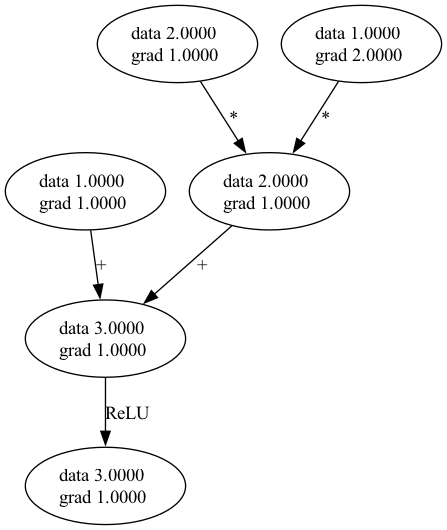

In [4]:
let x = Value::from(1.0);
let y = (x * Value::from(2) + Value::from(1)).relu();
y.backward();
draw_dot(y);

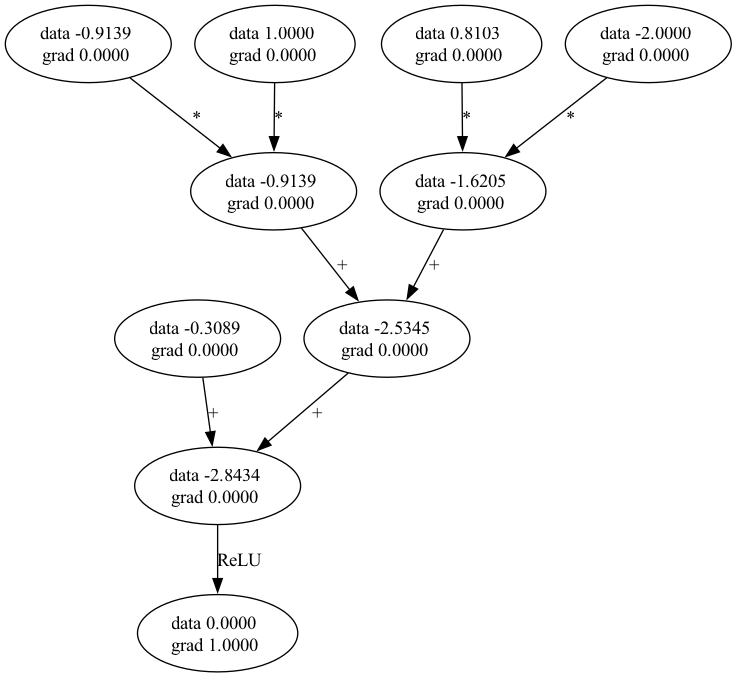

In [5]:
let n = Neuron::new(2, true);
let x = vec![Value::from(1.0), Value::from(-2.0)];
let y = n.forward(&x);
&y.backward();
draw_dot(y);